#  STOCK MARKET PREDICTION AND FORCASTING USING STACKED LSTM
 # LGM PROJECT TASK 2
 # BY ADENIYI SAMUEL

# OBJECTIVES
TO PREDICT AND FORECAST STOCK MARKET PRICES USIND THE STACKRD LSTM (LONG SHORT TERM MEMORY)

# Importing Neccessary Libraries

In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
%matplotlib inline
from warnings import filterwarnings
filterwarnings("ignore")

# Loading the dataset

In [2]:
df = pd.read_csv("/content/NSE-TATAGLOBAL.csv")

In [3]:
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


## **Exploratory Data Analysis**

In [4]:
# Checking The Shape Of The Data
df.shape

(2035, 8)

In [6]:
# Check The Descriptive Statistics Of the Data
df.describe()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,2035.000000,2035.000000,2035.000000,2035.000000,2035.00000,2.035000e+03,2035.000000
mean,149.713735,151.992826,147.293931,149.474251,149.45027,2.335681e+06,3899.980565
std,48.664509,49.413109,47.931958,48.732570,48.71204,2.091778e+06,4570.767877
min,81.100000,82.800000,80.000000,81.000000,80.95000,3.961000e+04,37.040000
25%,120.025000,122.100000,118.300000,120.075000,120.05000,1.146444e+06,1427.460000
50%,141.500000,143.400000,139.600000,141.100000,141.25000,1.783456e+06,2512.030000
75%,157.175000,159.400000,155.150000,156.925000,156.90000,2.813594e+06,4539.015000
max,327.700000,328.750000,321.650000,325.950000,325.75000,2.919102e+07,55755.080000


In [7]:
# Check Basic Information About The Data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035 entries, 0 to 2034
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  2035 non-null   object 
 1   Open                  2035 non-null   float64
 2   High                  2035 non-null   float64
 3   Low                   2035 non-null   float64
 4   Last                  2035 non-null   float64
 5   Close                 2035 non-null   float64
 6   Total Trade Quantity  2035 non-null   int64  
 7   Turnover (Lacs)       2035 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 127.3+ KB


In [9]:
# Check For missing values
df.isnull().sum()

Date                    0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
Total Trade Quantity    0
Turnover (Lacs)         0
dtype: int64

# checking the close values 

In [11]:
df_close = df.reset_index()['Close']
df_close

0       233.75
1       233.25
2       234.25
3       236.10
4       233.30
         ...  
2030    118.65
2031    117.60
2032    120.65
2033    120.90
2034    121.55
Name: Close, Length: 2035, dtype: float64

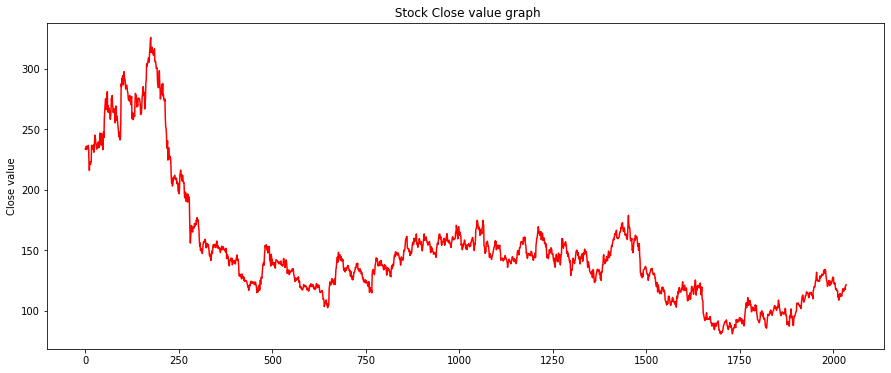

In [13]:
plt.figure(figsize=(15,6))
plt.plot(df_close)
plt.ylabel("Close value")
plt.title(' Stock Close values')
plt.show()

THE CLOSE VALUES REDUCES WITH TIME

# Checking the Stock High Values

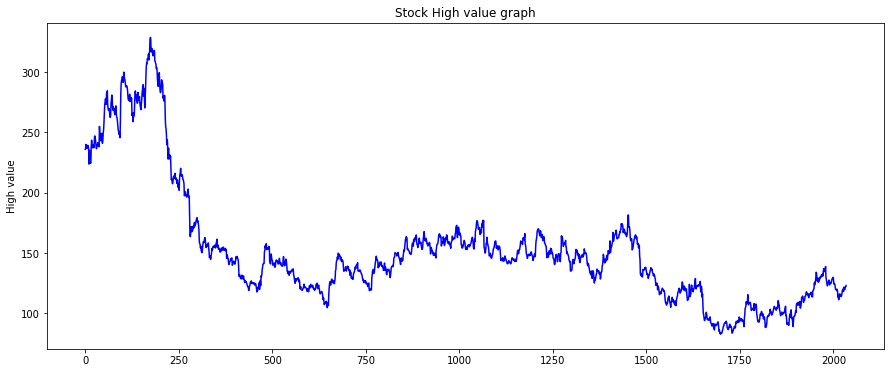

In [17]:
plt.figure(figsize=(15,6))

df_high = df.reset_index()['High']
plt.plot(df_high)
plt.ylabel("High values")
plt.title('Stock High value')
plt.show()

THE HIGH VALUES EXPERIENCED A SHARP DIP AFTER WHICH IT EVENTUALLY MOVES IN A STABLE MANNER

# Checking open Stock Graph

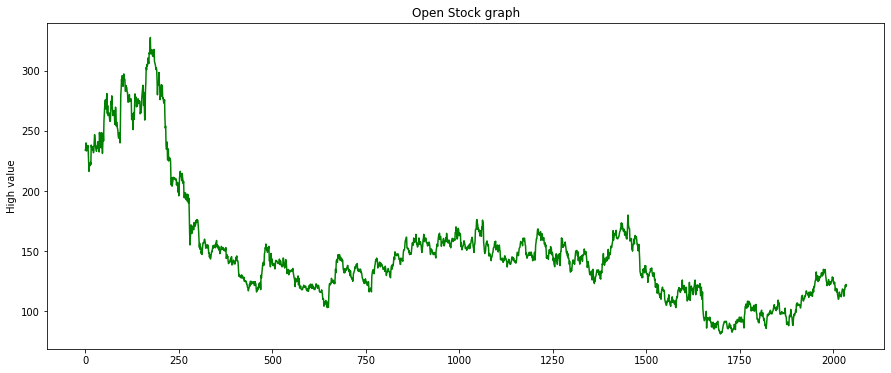

In [18]:
plt.figure(figsize=(15,6))

df_open=df.reset_index()['Open']
plt.plot(df_open)
plt.ylabel("High value")
plt.title('Open Stock')
plt.show()

THE OPEN VALUES HAVE THE SAME PATTERN AS THE HIGH VALUES

# Rescaling the dataset


In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
df_high = scaler.fit_transform(np.array(df_high).reshape(-1,1))
df_high

array([[0.62268754],
       [0.62614353],
       [0.6391543 ],
       ...,
       [0.15917869],
       [0.15938199],
       [0.16344786]])

# splitting the dataset into train and test set

In [21]:
training_set = int(len(df_high) * 0.75)
test_set = len(df_high) - training_set
train_data, test_data = df_high[0:training_set,:], df_high[training_set:len(df_high),:1]

# **Data Preprocessing**

In [24]:
def create_dataset(df, time_step = 1):
    dataX, dataY = [], []
    for i in range(len(df) - time_step - 1):
        a = df[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(df[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [25]:
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

# Using Long Short Term Memory Technique


In [26]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# Import Important LSTM libraries

In [30]:
import math
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM

In [32]:
# Confirming My TensorFlow Version
tf.__version__

'2.9.2'

# **Creating LSTM Model**

In [37]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_7 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


## **Model Training**

In [39]:
model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
23/23 [==============================] - 16s 357ms/step - loss: 0.0310 - val_loss: 0.0074
Epoch 2/100
23/23 [==============================] - 7s 325ms/step - loss: 0.0038 - val_loss: 0.0014
Epoch 3/100
23/23 [==============================] - 7s 323ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 4/100
23/23 [==============================] - 7s 322ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 5/100
23/23 [==============================] - 7s 323ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 6/100
23/23 [==============================] - 7s 323ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 7/100
23/23 [==============================] - 7s 325ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 8/100
23/23 [==============================] - 7s 325ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 9/100
23/23 [==============================] - 7s 324ms/step - loss: 0.0011 - val_loss: 7.1504e-04
Epoch 10/100
23/23 [==============================] - 8s 327ms/step - loss: 0.0013 - v

In [40]:
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# Transforming to Original Form

In [41]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Evaluating RMSE performance metrics

In [42]:
math.sqrt(mean_squared_error(y_train, train_predict))

162.65494767582993

### **Test Data RMSE**

In [43]:
math.sqrt(mean_squared_error(y_test, test_predict))

107.63766942064488

# Training set versusTesting Data

In [44]:
#Shifting train prediction for plotting
look_back = 100
trainPredictPlot = np.empty_like(stock_data_high)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

#Shifting test prediction for plotting
testPredictPlot = np.empty_like(stock_data_high)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2)+1:len(stock_data_high) - 1, :] = test_predict

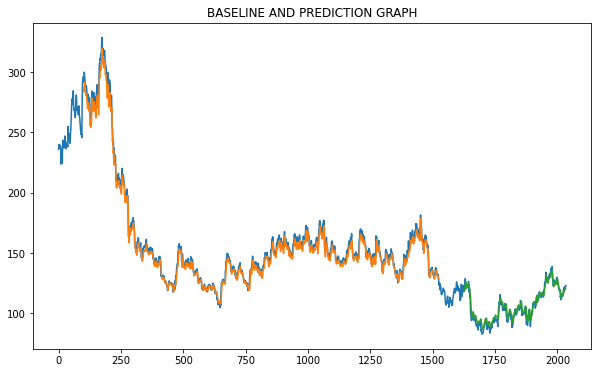

The Green Color indicates the Predicted Stock Data
The Blue Color indicates the Complete Stock Data
The Orange Color indicates the Stock Train Data


In [48]:
#Plotting baseline and predictions
plt.figure(figsize=(10,6))

plt.plot(scaler.inverse_transform(stock_data_high))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.title("baseline prediction")
plt.show()


# Predicting Stock Values For The Next 40 Days

In [53]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [74]:
lst_output=[]
n_steps=100
i=0
while(i<40):
    
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]

        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    



0 day input [0.14948905 0.14860427 0.14778171 0.14701758 0.14630835 0.14565098
 0.14504278 0.14448124 0.14396404 0.14348887 0.14305325 0.14265482
 0.14229099 0.14195926 0.14165697 0.14138164 0.14113075 0.14090197
 0.14069308 0.14050196 0.14032677 0.14016581 0.14001745 0.13988039
 0.13975336 0.13963535 0.13952543 0.13942268 0.13932659 0.13923636
 0.13915163 0.13907181 0.13899659 0.13892564 0.1388586  0.13879529
 0.1387354  0.13867879 0.13862526 0.13857463 0.1385268  0.13848157
 0.13843882 0.13839848 0.13836037 0.13832444 0.13829055 0.13825861
 0.13822852 0.13820019 0.13817355 0.13814846 0.1381249  0.13810278
 0.138082   0.13806248 0.13804415 0.138027   0.13801086 0.13799575
 0.13798156 0.1379683  0.13795583 0.13794413 0.13793319 0.13792296
 0.13791333 0.13790435 0.13789591 0.13788798 0.13788059 0.13787362
 0.13786711 0.13786101 0.13785526 0.1378499  0.13784483 0.13784014
 0.13783568 0.13783154 0.13782761 0.13782395 0.13782053 0.13781731
 0.13781428 0.13781142 0.13780878 0.13780628 0.137

In [ ]:
day_new = np.arange(1,101)
day_pred = np.arange(101,141)

##  Actual values in last 100 days And Predicted Stock Values In 40 Days

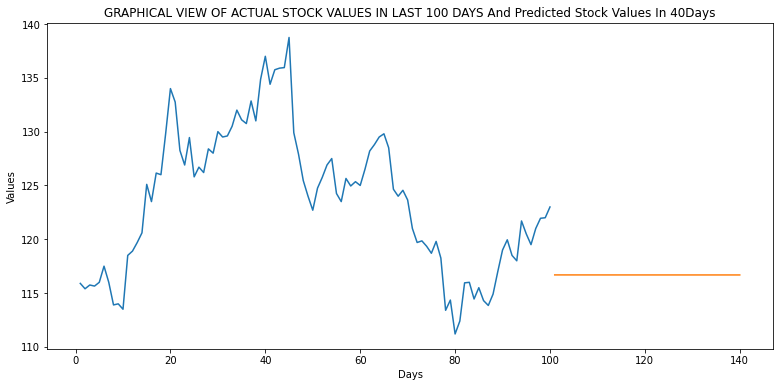

In [76]:
plt.figure(figsize=(13,6))

plt.plot(day_new, scaler.inverse_transform(df_high[1935:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))
plt.title("GRAPHICAL VIEW OF ACTUAL STOCK VALUES IN LAST 100 DAYS And Predicted Stock Values In 40Days")
plt.xlabel('Days')
plt.ylabel('Values')

plt.show()

### The Blue Color Line Shows The Actual Stock Value Trend In Last 100 Days

### The Red Color Line Shows The Predicted Stock Value Trend In Next 40 Days